In [1]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

# SVM Classification using Random Fourier Features Kernel

First, we read in MNIST data and create two sets of training and testing data, containing $1000$ and $10000$ samples, respectively. These will be used for various experiments

In [2]:
mnist = pd.read_csv('../datasets/mnist/train.csv')
# mnist = pd.read_csv('../datasets/fashion/fashion-mnist_test.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

n,d = X.shape


large_X = full_X[:10000]
large_y = full_y[:10000]
large_X_train, large_X_test, large_y_train, large_y_test = train_test_split(large_X, large_y, test_size=0.2, random_state=15)

In [3]:
def generate_kernel(m=350, s=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    W = np.random.multivariate_normal(mean=np.zeros(d), cov=2*s*np.eye(d), size=m) # m x d
    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return z1 @ z2.T / m
    return ker

#### Time comparison on $10,000$ MNIST images

First, we compare the time needed to train and test a SVM on $10000$ MNIST images ($784$ features)

In [4]:
start = perf_counter()
svm = SVC(gamma='auto')
svm.fit(large_X_train, large_y_train)
det_score = svm.score(large_X_test, large_y_test)
end = perf_counter()
det_time = end - start


iterations = 100
scores = np.empty(iterations)
times = np.empty(iterations)

for i in tqdm(range(iterations)):
    start = perf_counter()
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(large_X_train, large_y_train)
    end = perf_counter()
    times[i] = end - start
    scores[i] = random_svm.score(large_X_test, large_y_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:47<00:00,  2.88s/it]


In [5]:
print(f'Gaussian kernel: Accuracy: {det_score}, time: {det_time}')
print(f'Random kernel: Mean accuracy: {np.mean(scores)}, stdev: {np.std(scores)}, mean time: {np.mean(times)}')
print(f'Acc. stats: Q0: {np.min(scores)}, Q1: {np.quantile(scores, 0.25)}, Q2: {np.median(scores)}, Q3: {np.quantile(scores,0.75)}, Q4: {np.max(scores)}')

Gaussian kernel: Accuracy: 0.9195, time: 39.5625045
Random kernel: Mean accuracy: 0.8900499999999998, stdev: 0.004082584965435508, mean time: 2.208678119
Acc. stats: Q0: 0.8795, Q1: 0.887875, Q2: 0.89, Q3: 0.8925, Q4: 0.904


We observe that the random Fourier features kernel comes close to the deterministic Gaussian kernel in terms of accuracy ($96.75\%$ as accurate as deterministic), but takes only about $5.9\%$ as long. Considering the impressively low standard deviation makes this approach very useful for large datasets.

## Accuracy as a function of gamma

For the remainder of the experiments, we switch to a subset of MNIST containing only $1000$ samples. This is because the large dataset is useful for timing comparisons, but makes many of the following experiments computationally intractable.

First, we example the effect of varying gamma on the accuracy of the SVM, using both a deterministic and random kernel.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
domain = (1/784) * np.asarray([.125,.25,.5,1,2,4,8,16,32,64,128])

### Deterministic Gaussian kernel

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Text(0.5, 1.0, 'Deterministic Gaussian kernel SVM')

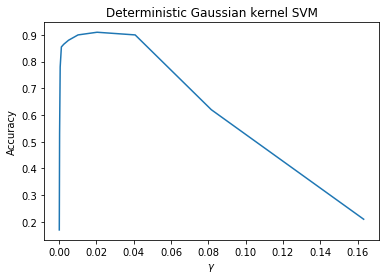

In [7]:
scores = []

for val in tqdm(domain):
    svm = SVC(gamma=val)
    svm.fit(X_train, y_train)
    scores.append(svm.score(X_test, y_test))
    
plt.plot(domain, scores)
plt.xlabel('$\gamma$')
plt.ylabel('Accuracy')
plt.title('Deterministic Gaussian kernel SVM')

### Random Fourier features approximation of Gaussian kernel

In [8]:
iterations = 100
scores = np.empty((domain.shape[0], iterations))
    
for i,val in enumerate(domain):
    for j in range(iterations):
        random_svm = SVC(kernel=generate_kernel(s=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)

stat = np.empty((7, domain.shape[0]))
stat[0] = np.min(scores, axis=1)
stat[1] = np.quantile(scores, 0.25, axis=1)
stat[2] = np.median(scores, axis=1)
stat[3] = np.quantile(scores, 0.75, axis=1)
stat[4] = np.max(scores, axis=1)
stat[5] = np.mean(scores, axis=1)
stat[6] = np.std(scores, axis=1)

Text(0.5, 1.0, "Randomized Kernel SVM accuracy 'continuous boxplot'")

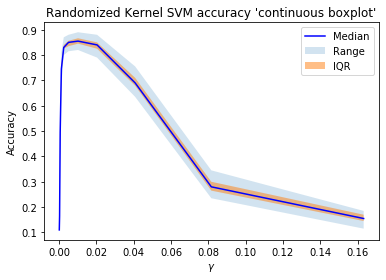

In [9]:
plt.plot(domain, stat[2], c='b', label='Median')
plt.fill_between(domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('$\gamma$')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy \'continuous boxplot\'')

In the randomized case, we sample $\mathbf{w}_i \sim N(0,2\gamma\mathbf{I})$ to approximate a deterministic rbf kernel with parameter $\gamma$.

### Accuracy as a function of $m$ (number of random Fourier features sampled)

In [10]:
m_domain = np.asarray([10, 50, 100, 200, 400, 750])
np.arange(start=100, stop=800, step=100)

array([100, 200, 300, 400, 500, 600, 700])

In [11]:
iterations = 100
scores = np.empty((m_domain.shape[0], iterations))
times = np.empty((m_domain.shape[0], iterations))
    
for i,val in enumerate(m_domain):
    for j in range(iterations):
        st = perf_counter()
        random_svm = SVC(kernel=generate_kernel(m=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)
        times[i,j] = perf_counter() - st
        
stat = np.empty((7, m_domain.shape[0]))
stat[0] = np.min(scores, axis=1)
stat[1] = np.quantile(scores, 0.25, axis=1)
stat[2] = np.median(scores, axis=1)
stat[3] = np.quantile(scores, 0.75, axis=1)
stat[4] = np.max(scores, axis=1)
stat[5] = np.mean(scores, axis=1)
stat[6] = np.std(scores, axis=1)

meantimes = np.mean(times, axis=1)

In [12]:
st = perf_counter()
det_svm = SVC(gamma='auto')
det_svm.fit(X_train, y_train)
det_svm.score(X_test, y_test)
det_time = perf_counter() - st

relativemeantimes = meantimes / det_time

Text(0.5, 1.0, 'Randomized Kernel SVM accuracy as a function of m')

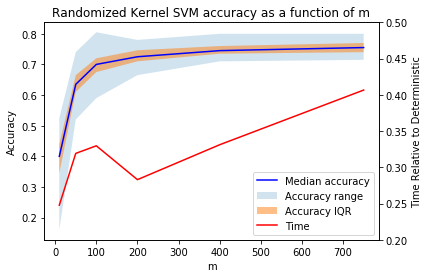

In [13]:
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(m_domain, stat[2], c='b', label='Median accuracy')
ax1.fill_between(m_domain, stat[4], stat[0], alpha=0.2, label='Accuracy range', lw=1)
ax1.fill_between(m_domain, stat[1], stat[3], alpha=0.5, label='Accuracy IQR', lw=1)
ax1.set_xlabel('m')
ax1.set_ylabel('Accuracy')
#plt.set_yscale('log')

ax2.plot(m_domain, relativemeantimes, c='r', label='Time')
ax2.set_ylabel('Time Relative to Deterministic')
ax2.set_ylim(0.2,0.5)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='lower right')

plt.title('Randomized Kernel SVM accuracy as a function of m')

## Randomly Approximating the Kernel over a range of parameters

Refer to section $4.4$ for documentation of this method. The goal is to approximate a kernel as a random sample average over a range of parameters, useful for when the optimal parameter value is unknown but an approximate range is known. In this case, we use a _sinc_ kernel as the underlying parametric family being approximated. Letting $B$ denote the parameter of the sinc kernel, we sampled $B$ uniformly from the range $(0.5,4)$ for the following experiments.

## Experiments

### Deterministic Gaussian Kernel with Default $\gamma$

In [15]:
gamma_val = 'auto'

In [16]:
det_svm = SVC(gamma=gamma_val)
det_svm.fit(X_train, y_train)
det_score = det_svm.score(X_test, y_test)

In [17]:
iterations = 100
det_times = np.empty((iterations))

for i in trange(iterations):
    start = perf_counter()
    det_svm = SVC(gamma=gamma_val)
    det_svm.fit(X_train, y_train)
    _ = det_svm.score(X_test, y_test)
    det_times[i] = perf_counter() - start

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


In [18]:
print(f'Accuracy: {det_score}, time: {np.mean(det_times)}')

Accuracy: 0.855, time: 0.8909091019999994


### Randomized Sinc Kernel

In [28]:
def generate_kernel(m=350, s=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    std = np.sqrt(2*s)
    W = np.random.uniform(low=-std, high=std, size=(m,d))
    def ker(x, y):
        z1 = np.cos(x @ W.T + b)
        z2 = np.cos(y @ W.T + b)
        return z1 @ z2.T / m
    return ker

In [29]:
iterations = 100
scores = np.empty((domain.shape[0], iterations))
    
for i,val in enumerate(domain):
    for j in range(iterations):
        random_svm = SVC(kernel=generate_kernel(s=val))
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)

stat = np.empty((7, domain.shape[0]))
stat[0] = np.min(scores, axis=1)
stat[1] = np.quantile(scores, 0.25, axis=1)
stat[2] = np.median(scores, axis=1)
stat[3] = np.quantile(scores, 0.75, axis=1)
stat[4] = np.max(scores, axis=1)
stat[5] = np.mean(scores, axis=1)
stat[6] = np.std(scores, axis=1)

Text(0.5, 1.0, "Randomized Averaged Sinc Kernel SVM accuracy 'continuous boxplot'")

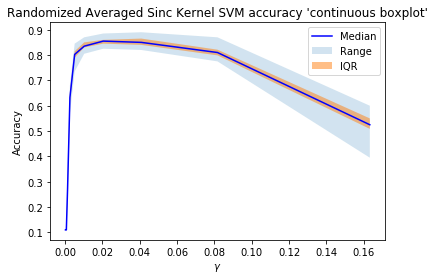

In [30]:
plt.plot(domain, stat[2], c='b', label='Median')
plt.fill_between(domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('$\gamma$')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Averaged Sinc Kernel SVM accuracy \'continuous boxplot\'')

### Randomized Averaged Sinc Kernel

In [31]:
def generate_kernel(m=100, q=10, s=1/d, scale=True):
    q_arr = np.random.uniform(low=0.5, high=4, size=q) 
    if scale:
        s = s/np.var(X_train)
    std = np.sqrt(2*s)
    W = np.random.uniform(low=-std*q_arr, high=std*q_arr, size=(m,d,q))
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m,1))
    
    def ker(x, y):
        z1 = np.cos(np.dot(x, W) + b)
        z2 = np.cos(np.dot(y, W) + b)
        res = np.tensordot(z1, z2, axes=([1,2],[1,2])) / (m*q)
        return res
    
    return ker

In [32]:
iterations = 100
scores = np.empty((iterations))
times = np.empty((iterations))
    

for i in trange(iterations):
    start = perf_counter()
    random_svm = SVC(kernel=generate_kernel())
    random_svm.fit(X_train, y_train)
    scores[i] = random_svm.score(X_test, y_test)
    times[i]= perf_counter() - start

stat = np.empty(7)
stat[0] = np.min(scores)
stat[1] = np.quantile(scores, 0.25)
stat[2] = np.median(scores)
stat[3] = np.quantile(scores, 0.75)
stat[4] = np.max(scores)
stat[5] = np.mean(scores)
stat[6] = np.std(scores)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:50<00:00,  2.91s/it]


In [33]:
print(f'Mean accuracy: {stat[5]}, stdev: {stat[6]}, mean time: {np.mean(times)}')
print(f'Acc. stats: Q0: {stat[0]}, Q1: {stat[1]}, Q2: {stat[2]}, Q3: {stat[3]}, Q4: {stat[4]}')

Mean accuracy: 0.8537999999999998, stdev: 0.02333580939243377, mean time: 2.9084587269999975
Acc. stats: Q0: 0.755, Q1: 0.845, Q2: 0.855, Q3: 0.87, Q4: 0.89


#### Histogram of Accuracies

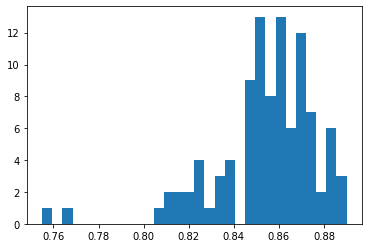

In [34]:
plt.hist(scores, bins=30);

#### Histogram of Times

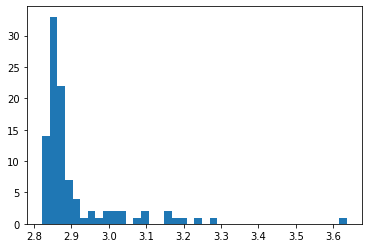

In [35]:
plt.hist(times, bins=40);

#### 2D Histogram of Accuracies, Times

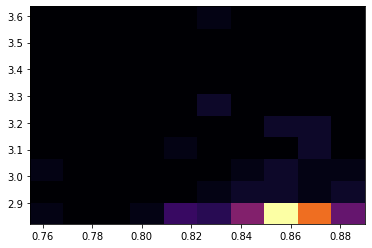

In [36]:
plt.hist2d(scores, times, bins=10, cmap='inferno');

### 'Cheating' Randomized Method (Training on the Test Data)

The purpose of this experiment is to see whether the model is able to recover all of the modes that it learns on.

In [37]:
iterations = 100
cscores = np.empty((iterations))
ctimes = np.empty((iterations))
    

for i in trange(iterations):
    start = perf_counter()
    crandom_svm = SVC(kernel=generate_kernel())
    crandom_svm.fit(X_test, y_test) # caution: do not blindly copy this code.
                                   # training on the test data is generally frowned upon.
    cscores[i] = crandom_svm.score(X_test, y_test)
    ctimes[i]= perf_counter() - start

cstat = np.empty(7)
cstat[0] = np.min(cscores)
cstat[1] = np.quantile(cscores, 0.25)
cstat[2] = np.median(cscores)
cstat[3] = np.quantile(cscores, 0.75)
cstat[4] = np.max(cscores)
cstat[5] = np.mean(cscores)
cstat[6] = np.std(cscores)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


In [38]:
print(f'Mean accuracy: {cstat[5]}, stdev: {cstat[6]}, mean time: {np.mean(ctimes)}')
print(f'Acc. stats: Q0: {cstat[0]}, Q1: {cstat[1]}, Q2: {cstat[2]}, Q3: {cstat[3]}, Q4: {cstat[4]}')

Mean accuracy: 0.84235, stdev: 0.03380425269104466, mean time: 1.0643574390000048
Acc. stats: Q0: 0.755, Q1: 0.82, Q2: 0.845, Q3: 0.865, Q4: 0.915


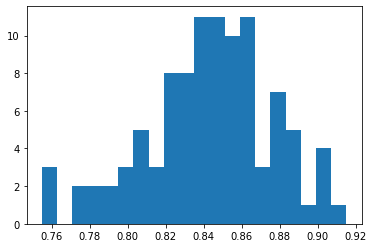

In [39]:
plt.hist(cscores, bins=20);

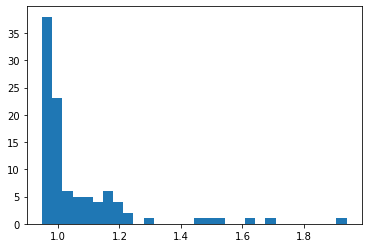

In [40]:
plt.hist(ctimes, bins=30);

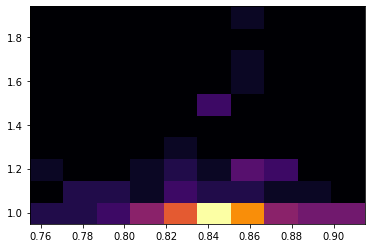

In [41]:
plt.hist2d(cscores, ctimes, bins=10, cmap='inferno');